In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

В данном модуле мы будем работать с текстовым признаком, извелкать из него полезную информацию, чтобы далее предсказывать направление ваканскии (признак "CФера") используя текстовое описание вакансии (признак "Обязанности")

## Выгрузим данные

In [6]:
df = pd.read_csv('for_text.csv')

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
df_text = df[['Обязанности']]   # оставим данный текстовый признак
df_text.head()

,Обязанности
0,Разработка простых интеграций для программы ло...
1,Участие в проектировании и реализации решений ...
2,Участвовать во всех этапах проекта: от проекти...
3,Разработка и внедрение <highlighttext>аналитик...
4,Ежедневный анализ децентрализованных и централ...


In [9]:
df['Обязанности'][100]

'Искать инсайты, формировать и проверять продуктовые гипотезы. Дизайнить и анализировать A/B тесты. Составлять и визуализировать метрики (продуктовые и операционные). '

## Токенизация

In [10]:
import warnings

import nltk
import pandas as pd
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

In [11]:
nltk.download("punkt", quiet=True)

True

Сначала сделаем самую простую токинизацию - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [12]:
dictionary = set() #для сохранения уникальных токенов
all_w = [] #для хранения всех токенов, чтобы проверить, как часто они встречаются

for line in df['Обязанности']:
    words = line.split()
    for word in words:
        word = word.replace('...', '')
        word = word.replace('<highlighttext>', '')
        word = word.replace('</highlighttext>', '')
        dictionary.add(word.lower())
        all_w.append(word.lower())

d = list(dictionary)
print(d[:25])

['интегратор', 'обратной', 'технически', 'код-ревью', 'сопутствующей', 'business', 'заказчиков-инвесторов.', 'safeguard', 'микросервисная', 'нуля”.', 'старшим', 'инфраструктуре', 'инцидентов,', 'интерфейса', 'часто', 'stack.', 'бизнес-заказчикам.', 'научные', 'надёжности,', 'склад', 'ожиданиями.', 'работными', 'requests).', 'проекты,', 'маркетинга).']


In [13]:
len(d) #уникальные токены

6225

In [14]:
len(all_w) #все токены

22520

In [15]:
#Посмотрим самые популярные токены

from collections import Counter
counts = Counter(all_w)
counts.most_common(10)

[('и', 1397),
 ('в', 643),
 ('с', 546),
 ('разработка', 464),
 ('на', 351),
 ('для', 312),
 ('-', 187),
 ('по', 186),
 ('участие', 156),
 ('поддержка', 147)]

Заметим, что по большей части это стоп-слова

In [16]:
# Удалим их

from nltk.corpus import stopwords
from string import punctuation

stop_words = stopwords.words("russian")
noise = stop_words + list(punctuation) #создадим список со стоп-словами и пунктуацией

all_w_n = np.array(all_w) #сделаем нампи эррей из листа со всеми токенами

mask = np.in1d(all_w_n, noise) #создаем маску, которая ищет стоп-слова и пунктуацию

all_w_new = list(all_w_n[~mask]) #оставляем только не стоп-слова 

print(len(set(all_w_new))) # заметим, что удалось удалить часть токенов
print(len(all_w_new))

6141
18142


In [17]:
# Снова найдем топ-10 слов

unique, counts = np.unique(all_w_new, return_counts=True)

sorted_ind_asc = np.argsort(counts)
sorted_ind_desc = np.argsort(counts)[::-1]

for i, j in zip(unique[sorted_ind_desc][:10], counts[sorted_ind_desc][:10]):
    print(f'Токен: {i}, частота: {j}')

Токен: разработка, частота: 464
Токен: участие, частота: 156
Токен: поддержка, частота: 147
Токен: работа, частота: 119
Токен: разрабатывать, частота: 112
Токен: новых, частота: 109
Токен: данных, частота: 98
Токен: разработке, частота: 73
Токен: данных., частота: 72
Токен: участвовать, частота: 72


In [18]:
# Теперь посмотрим на самые непопулярные токены

for i, j in zip(unique[sorted_ind_asc][:10], counts[sorted_ind_asc][:10]):
    print(f'Токен: {i}, частота: {j}')

Токен: "буржуй", частота: 1
Токен: направления,, частота: 1
Токен: направлениям, частота: 1
Токен: направленных, частота: 1
Токен: наращивать, частота: 1
Токен: нарушения, частота: 1
Токен: настоящим, частота: 1
Токен: настраивает, частота: 1
Токен: настроек, частота: 1
Токен: настроения, частота: 1


~"буржуй" и все слова на букву Н~

In [19]:
# Теперь используем токенезатор

new_d = []
for line in df['Обязанности']:
    words = word_tokenize(line)
    new_d.extend(words)

print(len(new_d)) #чекним сколько у нас токенов (в том числе повторяющихся), вышло чуть больше, чем до этого
print(new_d[:10]) #ну и пару слов выведем 

31467
['Разработка', 'простых', 'интеграций', 'для', 'программы', 'лояльности', 'в', 'приложениях', 'на', 'React']


In [20]:
len(set(new_d))  # уникальных токены, и заметим, что тут результаты улушились и слов стало немного меньше

5445

In [21]:
# Удалим шум

new_d_np = np.array(new_d)

mask = np.in1d(new_d_np, noise) #создаем маску, которая ищет шум

new_d_np_cleaned = new_d_np[~mask]

len(new_d_np_cleaned) #Ура! Токенов стало еще меньше

20153

In [22]:
#снова проверим топ-10 популярных токенов

unique, counts = np.unique(new_d_np_cleaned, return_counts=True)

sorted_ind_asc = np.argsort(counts)
sorted_ind_desc = np.argsort(counts)[::-1]

for i, j in zip(unique[sorted_ind_desc][:10], counts[sorted_ind_desc][:10]):
    print(f'Токен: {i}, частота: {j}')

Токен: ..., частота: 673
Токен: highlighttext, частота: 528
Токен: /highlighttext, частота: 528
Токен: Разработка, частота: 393
Токен: данных, частота: 205
Токен: Участие, частота: 122
Токен: новых, частота: 114
Токен: API, частота: 109
Токен: приложений, частота: 98
Токен: проектов, частота: 96


In [23]:
#Заметим, что в токенах остаются лишние символы, давайте напишем собственный tokenizer с учетом особенностей нашего текса

def custom_tokenizer(text):
    words = word_tokenize(text)
    all_w = []
    for word in words:
        word = word.replace('...', '')
        word = word.replace('highlighttext', '')
        word = word.replace('/highlighttext', '')
        word = word.replace('-', '')
        all_w.append(word.lower())
    dict_cleaned = []
    for token in all_w:
        if token not in noise and token != '' and token != ',':
            dict_cleaned.append(token)
    return dict_cleaned

In [24]:
# И попробуем использовать уже его 


new_d = []
for line in df['Обязанности']:
    words = custom_tokenizer(line)
    new_d.extend(words)

print(len(new_d)) #всего токенов
print(new_d[:10])

18303
['разработка', 'простых', 'интеграций', 'программы', 'лояльности', 'приложениях', 'react', 'native', 'создание', 'базовых']


In [25]:
#Посмотрим самые популярные. Как будто неплохо

from collections import Counter
counts = Counter(new_d)
counts.most_common(20)

[('разработка', 485),
 ('данных', 205),
 ('участие', 158),
 ('поддержка', 156),
 ('backend', 130),
 ('работа', 122),
 ('новых', 114),
 ('разрабатывать', 113),
 ('api', 111),
 ('приложений', 99),
 ('решений', 98),
 ('проектов', 96),
 ('frontend', 86),
 ('кода', 85),
 ('архитектуры', 81),
 ('функционала', 80),
 ('разработки', 79),
 ('системы', 79),
 ('тестирование', 78),
 ('проектирование', 78)]

In [26]:
# Проверим самые непопулярные токены. Обычно, если в тексте остались какие-то странные строки, мы можем заметить это по непопулярным токенам

unique, counts = np.unique(new_d, return_counts=True)

sorted_ind_asc = np.argsort(counts)
sorted_ind_desc = np.argsort(counts)[::-1]

for i, j in zip(unique[sorted_ind_asc][:10], counts[sorted_ind_asc][:10]):
    print(f'Токен: {i}, частота: {j}')

Токен: ️, частота: 1
Токен: инсайты, частота: 1
Токен: инстансов, частота: 1
Токен: инструкции, частота: 1
Токен: разработчикам, частота: 1
Токен: инструмент, частота: 1
Токен: разработок, частота: 1
Токен: разработки/сборки/тестирования/инсталляции, частота: 1
Токен: разработках, частота: 1
Токен: инсайтов, частота: 1


Заметим, что в нашем тексте много слов имеющих один и тот же корень, просто записанные в разной форме. Попробуем уменьшить словарь с помощью стемминга

## Стемминг

In [27]:
# Давайте поправим наш tokenizer добавив в него стемминг

from nltk import SnowballStemmer

def custom_stem_tokenizer(text):
    stemmer = SnowballStemmer("russian")
    dictionary_cleaned = custom_tokenizer(text)
    stemmed = [stemmer.stem(w) for w in dictionary_cleaned]
    return stemmed

In [28]:
# Используем теперь его

new_d = []
for line in df['Обязанности']:
    words = custom_stem_tokenizer(line)
    new_d.extend(words)

print(len(new_d)) #всего токенов
print(new_d[:10])

18303
['разработк', 'прост', 'интеграц', 'программ', 'лояльност', 'приложен', 'react', 'native', 'создан', 'базов']


In [29]:
# теперь снова проверим уникальные токены

len(set(new_d)) #Ура! Их осталось совсем немного по сравнению с тем, что было

3015

## Векторизация

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
X = cv.fit_transform(df['Обязанности'])
print(len(cv.vocabulary_))

3020


In [31]:
list(cv.vocabulary_.keys())[:25] # посмотрим токены

['разработк',
 'прост',
 'интеграц',
 'программ',
 'лояльност',
 'приложен',
 'react',
 'native',
 'создан',
 'базов',
 'компонент',
 'пользовательск',
 'интерфейс',
 'готов',
 'дизайнмакет',
 'участ',
 'проектирован',
 'реализац',
 'решен',
 'област',
 'ai/ml',
 'ключев',
 'проект',
 'университет',
 'формирован']

In [32]:
df.columns

Index(['Организация', 'Описание', 'Тип_занятости', 'Локация',
       'Ключевые навыки', 'Вакансия', 'ЗП_от', 'ЗП_до', 'Валюта',
       'Профессия_id', 'Требования', 'Обязанности', 'Расписание', 'Опыт',
       'Профессия', 'ЗП_сред', 'ЗП_сред_RUB', 'Локация_2', 'Сфера'],
      dtype='object')

In [33]:
# Посмотрим конкретную вакансию

ind = 555
df.iloc[ind]['Обязанности'], df.iloc[ind]['Сфера']

('Поддержкой, развитием и оптимизацией существующих проектов. Разработкой новой функциональности и улучшением имеющейся. Работать в тесной связке с <highlighttext>frontend</highlighttext>-разработчиком (фронт...',
 'Прога')

Применим обученный CountVectorizer для векторизации данного текста

In [34]:
a = [df.iloc[ind]['Обязанности']]

X = cv.fit_transform(a)
cv.vocabulary_.keys()

X.toarray() #Все токены уникальны и встречаются один раз, поэтому нельзя точно сказать, какой важнее

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

Теперь попробуем найти TF-IDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
X = tfidf_vec.fit_transform(df['Обязанности'])
importance = X[555].toarray()         #выгрузим "веса" каждого слово для интересующей нас вакансии
importance

array([[0., 0., 0., ..., 0., 0., 0.]])

In [36]:
ind = np.where(importance != 0)[1] #найдем индексы слов с ненулевым весом для выбранной вакансии
ind

array([ 391, 1933, 2707, 2862, 3125, 3489, 3572, 3603, 3651, 3660, 3895,
       4241, 4313, 4445, 4587, 4613], dtype=int64)

In [37]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
X = cv.fit_transform(df['Обязанности'])
print(len(cv.vocabulary_))

4779


In [38]:
cv.get_feature_names_out()[ind] #достанем эти слова

array(['frontend', 'имеющейся', 'новой', 'оптимизацией', 'поддержкой',
       'проектов', 'работать', 'развитием', 'разработкой',
       'разработчиком', 'связке', 'существующих', 'тесной', 'улучшением',
       'фронт', 'функциональности'], dtype=object)

In [39]:
pd.DataFrame(importance[:, ind], columns=cv.get_feature_names_out()[ind]) #а теперь сделаем красивый датафреймик

,frontend,имеющейся,новой,оптимизацией,поддержкой,проектов,работать,развитием,разработкой,разработчиком,связке,существующих,тесной,улучшением,фронт,функциональности
0,0.160564,0.322237,0.252621,0.292255,0.218516,0.160052,0.197214,0.274716,0.198432,0.262273,0.304699,0.166046,0.304699,0.282603,0.274716,0.238066


## Обучение моделей

In [40]:
def change(raw):
    if raw['Сфера'] == 'Прога':
        return 1
    else:
        return 0
df['Сфера_id'] = df.apply(change, axis=1)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split

In [42]:
X = df['Обязанности']
y = df['Сфера_id']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [43]:
X_train.head()

641     Построение / Управление / Обучение команды <hi...
1181    Система слежения за автопарком компании с помо...
830     Мы используем и разрабатываем сложную архитект...
1247    Мы в поиске грамотного python-разработчика, в ...
693                 Разработка DMA инфраструктуры с нуля.
Name: Обязанности, dtype: object

In [44]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train)  # bow — bag of words (мешок слов)
bow_test = vec.transform(X_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow)
pred_test = clf.predict(bow_test) 

print(accuracy_score(y_train, pred)) #вышел довольно неплохо скор
print(accuracy_score(y_test, pred_test))

0.997737556561086
0.8842105263157894


In [45]:
df['Сфера_id'].value_counts()

Сфера_id
1    1001
0     263
Name: count, dtype: int64

In [46]:
y = df['Сфера_id']

In [47]:
# Теперь давайте попробуем взвесить классы, поскольку у нас явный дисбаланс классов

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = {0: class_weights[0], 1: class_weights[1]}

vec = CountVectorizer(ngram_range=(1, 1), tokenizer=custom_stem_tokenizer)
bow = vec.fit_transform(X_train)  # bow — bag of words (мешок слов)
bow_test = vec.transform(X_test)

clf = LogisticRegression(max_iter=200, random_state=55, class_weight=class_weights)
clf.fit(bow, y_train)
pred = clf.predict(bow)
pred_test = clf.predict(bow_test) 

print(accuracy_score(y_train, pred)) # скор даже вырос
print(accuracy_score(y_test, pred_test))

0.9920814479638009
0.881578947368421


In [48]:
# возьмем теперь другой векторайзер

vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=custom_stem_tokenizer)
vec_train = vec.fit_transform(X_train)
vec_test = vec.transform(X_test)

clf = LogisticRegression(max_iter=300, random_state=55, class_weight=class_weights)
clf.fit(vec_train, y_train)
pred_tfidf_test = clf.predict(vec_test)
pred_tfidf = clf.predict(vec_train)

print(accuracy_score(y_train, pred_tfidf))
print(accuracy_score(y_test, pred_tfidf_test)) # тут на скор ниже

0.9626696832579186
0.881578947368421


In [49]:
# А теперь попробуем рандомно удалить часть вакансий по направлению программирование для достижения баланса классов
# и снова обучить модели
ana_indices = np.where(y == 0)[0] 
proga_indices = np.random.choice(np.where(y != 0)[0], size=len(ana_indices))
indices = np.concatenate((ana_indices, proga_indices))
X = X[indices]
y = y[indices]

In [50]:
y.value_counts()

Сфера_id
0    263
1    263
Name: count, dtype: int64

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [52]:
# возьмем теперь другой векторайзер

vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=custom_stem_tokenizer)
vec_train = vec.fit_transform(X_train)
vec_test = vec.transform(X_test)

clf = LogisticRegression(max_iter=300, random_state=55)
clf.fit(vec_train, y_train)
pred_tfidf_test = clf.predict(vec_test)
pred_tfidf = clf.predict(vec_train)

print(accuracy_score(y_train, pred_tfidf))
print(accuracy_score(y_test, pred_tfidf_test)) 

0.970108695652174
0.8481012658227848


In [55]:
# Давайте еще посчитаем метрики

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(f"Precision: {precision_score(y_test, pred_tfidf_test > 0.5):.2f}")
print(f"Recall: {recall_score(y_test, pred_tfidf_test > 0.5):.2f}")
print(f"F1: {f1_score(y_test, pred_tfidf_test > 0.5):.2f}")

Precision: 0.85
Recall: 0.85
F1: 0.85


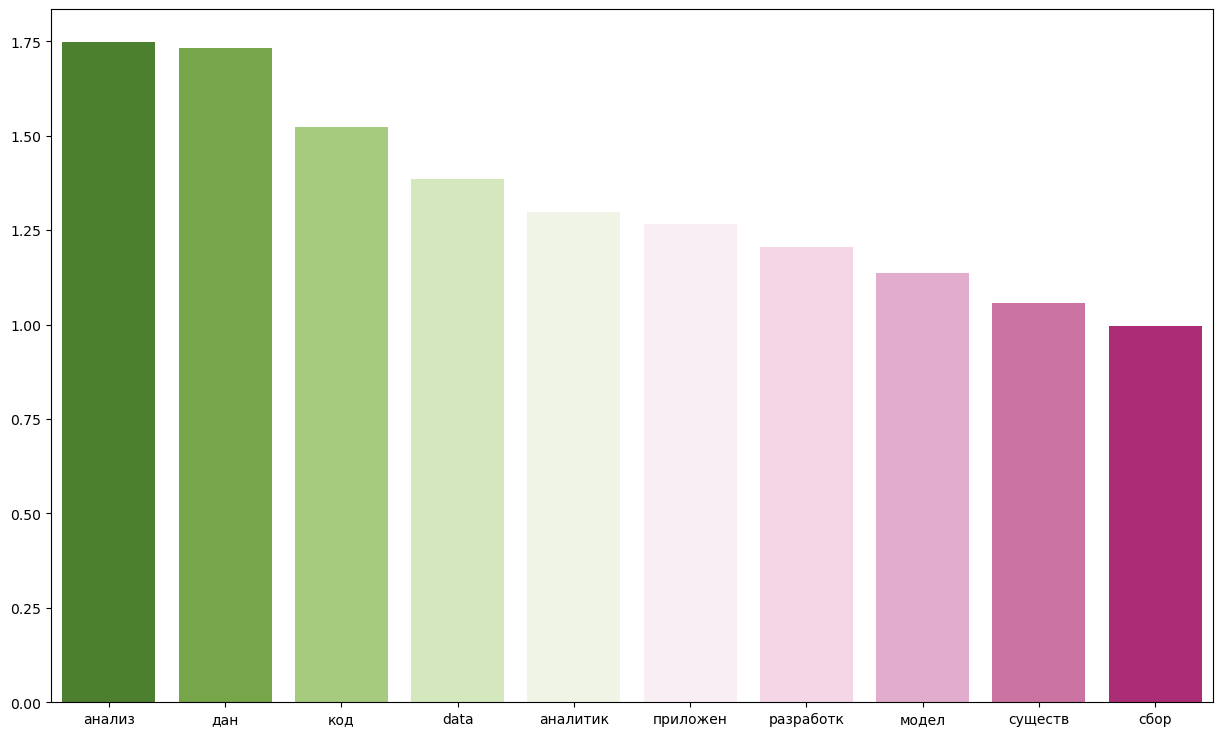

In [53]:
#В целом все довольно неплохо, жаль только, что на тесте и трейне такая разница, ведь может быть вероятность переобучения
#Поэтому предлагаю посмотреть на токены с наибольшим весом после обучения модели и оценить их веса

# Получаем коэффициенты модели
coefs = clf.coef_[0]

# Сортируем токены по модулю коэффициентов
sorted_tokens = sorted(vec.get_feature_names_out(), key=lambda x: abs(coefs[vec.vocabulary_[x]]), reverse=True)


co = []
for i in sorted_tokens[0:10]:
    co.append(abs(coefs[vec.vocabulary_[i]])) 

# Выводим berplot с 10 токенами с наибольшими по модулю положительными/отрицательными весами
plt.figure(figsize=(15, 9))
sns.barplot(x=sorted_tokens[0:10], y=co, palette='PiYG_r')
plt.show()

**Вывод:** модель справилась хорошо, токены адекватные и веса тоже. Признак "Обязанность" позволяет хорошо разделить вакансии программистов и вакансии аналитиков